In [70]:
from enum import Enum, auto
from dataclasses import dataclass, field
from typing import List
from copy import deepcopy
from itertools import combinations

from matplotlib import pyplot as plt

In [71]:
class BlockType(Enum):
    Sign = "sign"
    Digit = "digit"
    Equality = "equality"

In [108]:
SLOTS = {
    BlockType.Digit: (
        ((0, 0), (0, 1)),
        ((0, 0), (1, 0)),
        ((0, 1), (0, 2)),
        ((0, 1), (1, 1)),
        ((0, 2), (1, 2)),
        ((1, 0), (1, 1)),
        ((1, 1), (1, 2))
    ),
    BlockType.Sign: (
        ((0.5, 0.5), (0.5, 1.5)),
        ((0, 1), (1, 1))
    ),
    BlockType.Equality: (
        ((0, 0.5), (1, 0.5)),
        ((0, 1.5), (1, 1.5))
    )
}

class SlotColor:
    Empty = (0.7, 0.7, 0.7) # light grey
    Removed = "red"
    Added = "Green"
    Remaining = "yellow"

DIGITS = {
    (1, 1, 1, 0, 1, 1, 1): 0,
    (0, 0, 0, 0, 0, 1, 1): 1,
    (1, 1, 0, 1, 1, 0, 1): 2,
    (0, 1, 0, 1, 1, 1, 1): 3,
    (0, 0, 1, 1, 0, 1, 1): 4,
    (0, 1, 1, 1, 1, 1, 0): 5,
    (1, 1, 1, 1, 1, 1, 0): 6,
    (0, 0, 0, 0, 1, 1, 1): 7,
    (1, 1, 1, 1, 1, 1, 1): 8,
    (0, 1, 1, 1, 1, 1, 1): 9
}


In [109]:
class Block:
    def __init__(self, block_type : BlockType, matches : List = None):
        assert isinstance(block_type, BlockType)
        self.indicators = list(matches) if matches else []
        self.type = block_type
        self._validate()
    
    def _validate(self):
        assert all(indicator in {0, 1} for indicator in self.indicators)
        if self.type == BlockType.Equality:
            assert len(self.indicators) == 0
        elif self.type == BlockType.Sign:
            assert len(self.indicators) == 1
        else:
            assert self.type == BlockType.Digit
            assert len(self.indicators) == 7
    
    def add_match(self, index):
        assert self.indicators[index] == 0
        self.indicators[index] = 1
    
    def remove_match(self, index):
        assert self.indicators[index] == 1
        self.indicators[index] = 0

    def available_matches(self):
        return [slot for slot, indicator in enumerate(self.indicators) if indicator == 1]
    
    def absent_matches(self):
        return [slot for slot, indicator in enumerate(self.indicators) if indicator == 0]
    
    def is_valid(self):
        if self.type in {BlockType.Sign, BlockType.Equality}:
            return True
        return tuple(self.indicators) in DIGITS
    
    def get_str(self):
        assert self.is_valid()
        if self.type == BlockType.Equality:
            return "=="
        if self.type == BlockType.Sign:
            return "+" if self.indicators[0] else "-"
        if self.type == BlockType.Digit:
            return str(DIGITS[tuple(self.indicators)])

    @classmethod
    def from_digit(cls, digit):
        assert digit in range(10)
        for indicators, v in DIGITS.items():
            if v == digit:
                return cls(BlockType.Digit, indicators)
        assert False, "Can't find digit {}".format(digit)

class MatchConfiguration:
    def __init__(self, blocks):
        self.blocks = [Block(b.type, b.indicators) for b in blocks]
    
    @classmethod
    def from_str(cls, s):
        blocks = []
        for symbol in s:
            if symbol == "=":
                blocks.append(Block(BlockType.Equality))
            elif symbol in {"-", "+"}:
                blocks.append(Block(BlockType.Sign, [1 if symbol == "+" else 0]))
            else:
                blocks.append(Block.from_digit(int(symbol)))
        return cls(blocks)

    def is_valid(self):
        if any(not b.is_valid() for b in self.blocks):
            return False
        if all(b.type != BlockType.Equality for b in self.blocks):
            return True
        py_expression = "".join(b.get_str() for b in self.blocks)
        return eval(py_expression)
    
    def add_match(self, block_id, slot_index):
        self.blocks[block_id].add_match(slot_index)
    
    def remove_match(self, block_id, slot_index):
        self.blocks[block_id].remove_match(slot_index)

    def available_matches(self):
        result = []
        for block_id, block in enumerate(self.blocks):
            for slot_index in block.available_matches():
                result.append((block_id, slot_index))
        return result
    
    def absent_matches(self):
        result = []
        for block_id, block in enumerate(self.blocks):
            for slot_index in block.absent_matches():
                result.append((block_id, slot_index))
        return result
    


In [116]:
            
class Solution:
    def __init__(self, blocks, removed_matches=(), added_matches=()):
        self.block_types = [block.type for block in blocks]
        self.slot_colors = []
        for block in blocks:
            if block.type == BlockType.Equality:
                self.slot_colors.append([SlotColor.Remaining] * 2)
            elif block.type == BlockType.Sign:
                self.slot_colors.append(
                    [SlotColor.Remaining if block.indicators[0] else SlotColor.Empty,
                     SlotColor.Remaining]
                )
            else:
                self.slot_colors.append([
                    SlotColor.Remaining if i else SlotColor.Empty for i in block.indicators
                ])
        for block_id, slot_id in removed_matches:
            self.slot_colors[block_id][slot_id] = SlotColor.Removed
        for block_id, slot_id in added_matches:
            self.slot_colors[block_id][slot_id] = SlotColor.Added
                
    def plot(self, scale = 100, padding=20, figsize=(20, 10)):
        figure, axes = plt.subplots(1, len(self.block_types), squeeze=False, figsize=figsize)
        axes = axes[0]
        for block_type, colors, ax in zip(self.block_types, self.slot_colors, axes):
            ax.set_xlim(0, scale + 2 * padding)
            ax.set_ylim(0, 2 * scale + 2 * padding)
            ax.set_xticks([], [])
            ax.set_yticks([], [])
            ax.set_aspect('equal')
            for ((x, y), (x2, y2)), color in zip(SLOTS[block_type], colors):
                ax.arrow(
                    padding + scale * x,
                    padding + scale * y,
                    scale * (x2 - x),
                    scale * (y2 - y),
                    color = color,
                    linewidth=5
                )
#         figure.show()
        


In [117]:
def search_solutions(configuration, add_count, delete_count, verbose=False):
    available_matches = configuration.available_matches()
    absent_matches = configuration.absent_matches()
    solutions = []
    for removed_matches in combinations(available_matches, delete_count):
        for added_matches in combinations(absent_matches, add_count):
            for block_id, slot_index in removed_matches:
                configuration.remove_match(block_id, slot_index)
            for block_id, slot_index in added_matches:
                configuration.add_match(block_id, slot_index)
            if configuration.is_valid():
                solution = Solution(
                    configuration.blocks,
                    removed_matches,
                    added_matches
                )
                solutions.append(solution)
                if verbose:
                    solution.plot()
            for block_id, slot_index in removed_matches:
                configuration.add_match(block_id, slot_index)
            for block_id, slot_index in added_matches:
                configuration.remove_match(block_id, slot_index)
    return solutions

## Examples

[<__main__.Solution at 0x7f10998967f0>, <__main__.Solution at 0x7f109a9580b8>]

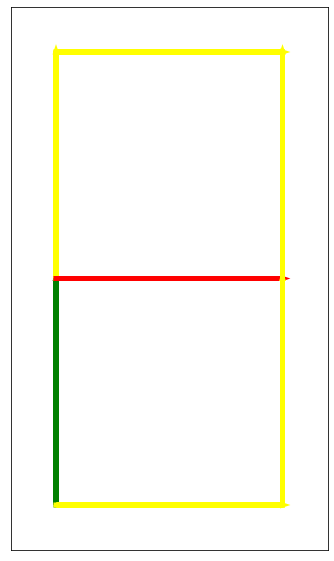

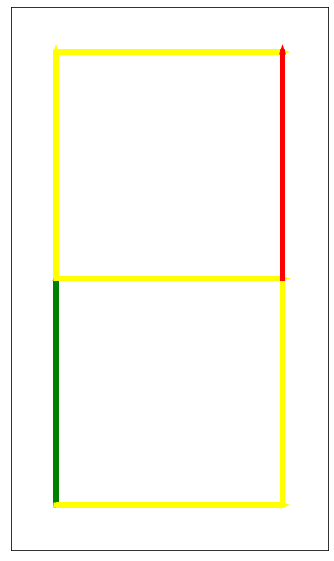

In [118]:
conf = MatchConfiguration([Block.from_digit(9)])
search_solutions(conf, 1, 1, verbose=True)

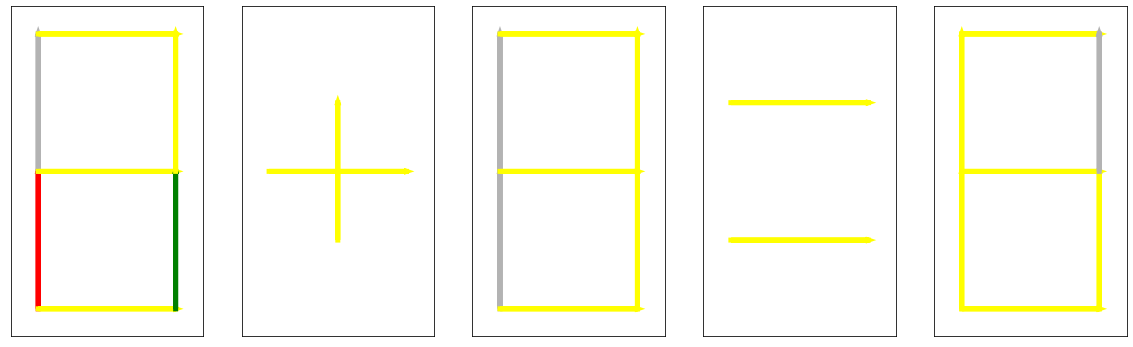

In [122]:
conf = MatchConfiguration.from_str("2+3=6")
search_solutions(conf, add_count=1, delete_count=1, verbose=True)

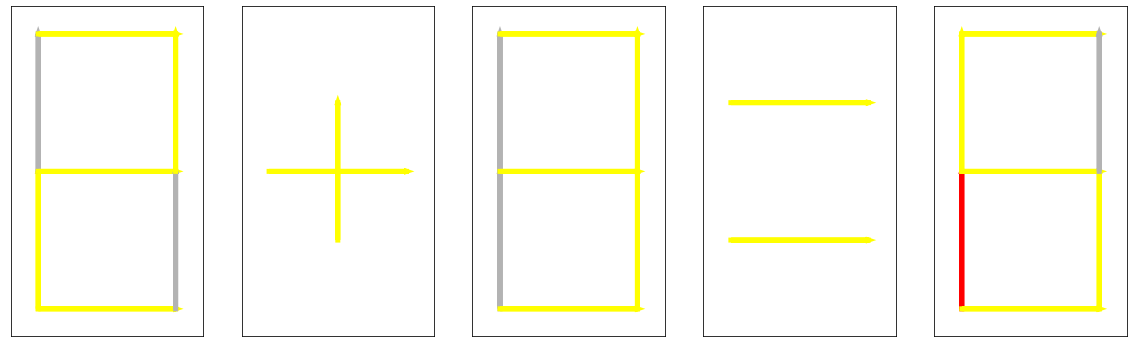

In [123]:
conf = MatchConfiguration.from_str("2+3=6")
search_solutions(conf, add_count=0, delete_count=1, verbose=True)

[<__main__.Solution at 0x7f1093515f60>, <__main__.Solution at 0x7f109378d7b8>]

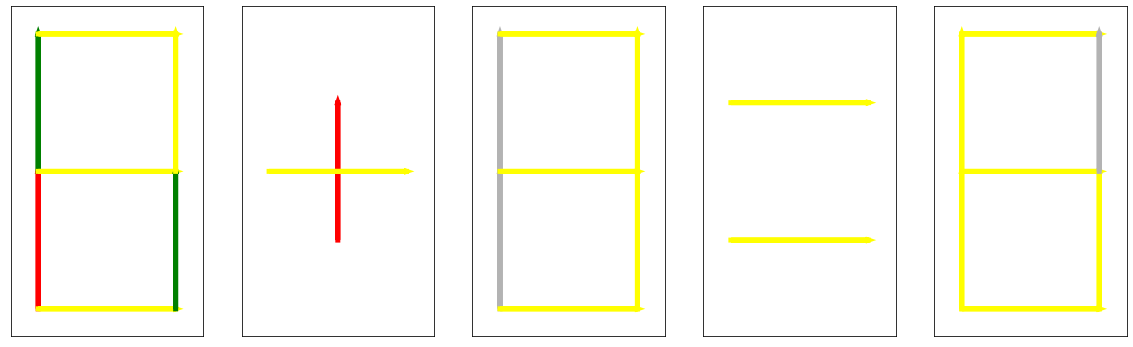

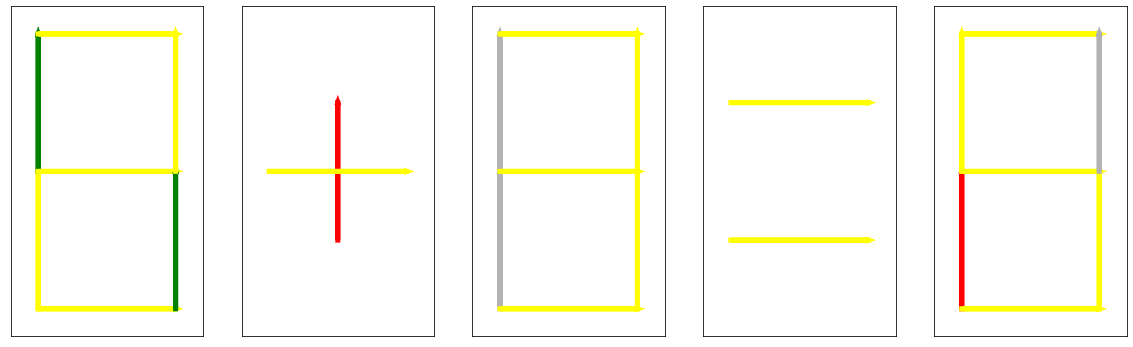

In [125]:
conf = MatchConfiguration.from_str("2+3=6")
search_solutions(conf, add_count=2, delete_count=2, verbose=True)

## Tests


In [54]:
# test block copy
block1 = Block(BlockType.Digit, [1] * 7)
block2 = deepcopy(block1)

assert block1.indicators == block2.indicators
assert not block1.indicators is block2.indicators
block1.remove_match(1)
assert block1.indicators != block2.indicators

assert not block1.is_valid()
assert block2.is_valid()

# test block validation
for indicators in DIGITS:
    assert Block(BlockType.Digit, indicators).is_valid()
assert not Block(BlockType.Digit, [0] * 7).is_valid()
assert not Block(BlockType.Digit, [0] * 2 + [1] * 5).is_valid()


/home/strashila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


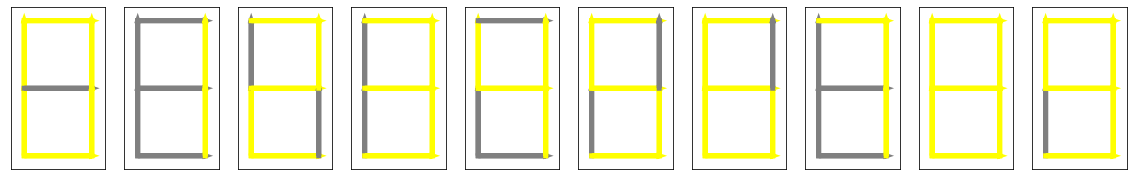

In [55]:
sol = Solution([Block.from_digit(i) for i in range(10)])
sol.plot()